<div class="clearfix" style="padding: 10px; padding-left: 0px">
<img src="https://raw.githubusercontent.com/jupyter/nature-demo/master/images/jupyter-logo.png" width="150px" style="display: inline-block; margin-top: 65px;">
<a href="http:///"><img src="http://2.bp.blogspot.com/-A-Q8pbwN-WQ/T9lf0H06GOI/AAAAAAAAAnQ/Z9v3rRDHI5Y/s320/gnu.jpg" width="240px" class="pull-right" style="display: inline-block; margin: 0px;"></a>
</div>

# Cory Pruce <br/>

### Triage Automation Early Data Analysis <br/> <br/>

<div class="alert alert-info" role="alert" style="margin: 10px">
<p>***Triaging*, assigning incoming Problem Reports to the responsible party, is a hard problem. <br/> <br/> 

While the root cause is many times outside the scope of the initial report, information is still usually provided upon first entry. Due to the illusive nature of several bugs, surface analysis will have a margin of error. Although not all PR's contain the necessary information for proper categorization, trends can be learned and the degree of separation reduced. **</p>
</div>

<div class="alert alert-success" role="alert" style="margin: 10px">
<p>
**Though classification is a difficult problem, any automation of this task will relieve engineers of the duty and allocate more time for developing new features, optimizing for engineer oppurtunity cost. At the very least, an automated, educated-guess will speed up the process that the right person sees the PR.**</p>
</div>

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>**Extract, transform, and load the meta-data to a sample set of PR's **</p>
</div>
</div>

In [25]:
%matplotlib inline
import re
import sys
import getopt
import logging
import datetime
import subprocess
from time import strptime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

total_prs_path = 'Spruce/data/201X_total_utf8.txt'
pickle_file = "Spruce/data/201X_total_pr_scopes.pickle"

"""
Data mining conducted via query-pr SQL translator tool for GNATS: https://manned.org/query-pr/bf527e7b
"""


"""
File line examples:
>Number:         {#} where # represents are monotonically increasing integer for the Problem Report's number 
>Category:       {X-Y-Z} where X and Y are tokens indicating a hierarchy of the team X-Y-Z
>Synopsis:       {Some brief overview of the symptom}
>Problem-Level:  ie. "3-IL1"
>Responsible{1}:  {Uname} where Uname is a username
>State{1}:       ie. "closed"
>Arrival-Date:   ie. "Fri Jan 01 00:21:27 -0800 201X"
>Last-Modified:  ie. "Fri Feb 10 10:25:26 -0800 201X"
>Closed-Date{1}: ie. "Tue Jan 06 00:48:25 -0800 201X"

# Convert file format into something parseable by python libraries
# iconv -c -f ISO-8859-9 -t UTF8 201X_total2.txt > 201X_total_utf8.txt
"""

def deepCopyDict(src, dst):
    for key in src:
        dst[key] = src[key]
    return dst

def extract_pr_scopes():
    df = pd.DataFrame(columns=["Number","Category", "Synopsis","Confidential","Problem-Level","Functional-Area",
                               "Class","Responsible","State","Planned-Release","Keywords","Submitter-Id","Arrival-Date",
                               "Last-Modified","Closed-Date","Originator","Reported-In"])
    df_ind = 0
    with open(total_prs_path, 'r') as infile:
        
        # parse entries into a list of PR field lists
        entries = [x.split('\n') for x in infile.read().split('\n\n')]
        scopes = set([])
        for i, entry in enumerate(entries):
            
            cur_pr_scopes = {}
            cur_pr, cur_scope = "", "1"
            for line in entry:
                
                # extract key, scope, value for each field in the PR entry
                field_match = re.match(r'>(.+?):\s+(.+)$', line)
                
                if field_match:
                    key, val = field_match.group(1), field_match.group(2)
                    scope_match = re.match(r'(.+){(\d+)}$', key)
                    if scope_match:
                        key = scope_match.group(1)
                        scope = scope_match.group(2)
                        cur_scope = scope
                        scopes.add(scope)
                    
                    if key == "Number":
                        # start of new PR entry
                        cur_pr = val
                        
                        cur_pr_scopes[cur_scope] = {}
                        scope_key = ''.join([cur_pr,'-',cur_scope])
                        cur_pr_scopes[cur_scope][key] = scope_key
                    else:
                        if cur_scope not in cur_pr_scopes:
                            cur_pr_scopes[cur_scope] = deepCopyDict(cur_pr_scopes["1"], {})
                            scope_key = ''.join([cur_pr,'-',cur_scope])
                            cur_pr_scopes[cur_scope]["Number"] = scope_key
                        cur_pr_scopes[cur_scope][key] = val
        
            
            for scope in cur_pr_scopes:
                planned_release = cur_pr_scopes[scope]["Planned-Release"]
                
                if 'DELETE' not in planned_release:
                    if df_ind % 1000 == 0:
                        print(df_ind)
                    df.loc[df_ind] = pd.Series(cur_pr_scopes[scope])
                    df_ind+=1
                    
            
        df.to_pickle(pickle_file)
        return df

In [26]:
try:
    scopes_df = pd.read_pickle(pickle_file)
    #print('Pickle file ({}) loaded'.format(pickle_file))
except Exception as e: 
    print(e)
    scopes_df = extract_pr_scopes()

closed = scopes_df.loc[scopes_df["State"]=="closed"]
opened = scopes_df.loc[scopes_df["State"]=="open"]
print('Number of closed PR scopes that arrived in 201X: Some large number') #{:,}'.format(closed.shape[0]))
print('Number of open PR scopes that arrived in 201X: Another larger number') #{:,}'.format(opened.shape[0]))
print('Number of scopes that arrived in 201X: And another\n') #{:,}\n'.format(scopes_df["Number"].count()))
uniq_prs = scopes_df["Number"].apply(lambda x: x[:-2])
uniq_prs = uniq_prs.drop_duplicates()
num_prs_2016 = uniq_prs.shape[0]

Number of closed PR scopes that arrived in 201X: Some large number
Number of open PR scopes that arrived in 201X: Another larger number
Number of scopes that arrived in 201X: And another



<div class="alert alert-success" role="alert" style="margin: 10px">
<p>
**The procedure above extracts meta-data for all PR's that arrived in 201X. These PR entries are then split into the scopes from the database and stored in pandas DataFrames. **</p>
</div>

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>**Extract, transform, and load the meta-data to the corresponding sample set of PR Category Changelogs. **</p>
</div>
</div>

In [14]:
chlog_path = 'Spruce/data/201X_chlog_cat.txt'
num_changes = 22*[0]
num_changes_dict = {}
num_changelog_prs = 0

"""
# Extraction of PR's arriving from January 1st 201X 00:00:00 to January 1st 2017 00:00:00.
# Format is 'PR Num: {Change-log Entries} Arrival-Date', where {Change-log Entries} are 
# a variable number of entries of the form 
# 'Datetime Field(Category) Category_From Category_To ------ '. From this information,
# times can be associated with each category and statistics modelled around the sampling.

# Data does not include final category as not to count for PR in the correct category. 
# Regarding the final category (for non-closed PR's), the final numbers produced are a 
# lower bound.

Query:
query-pr -e 'Arrival-Date > "201X-01-01"& Arrival-Date < "201Y-01-01"& 
    (change-log.field="Category")' -f '"%s %s %s" number change-log arrival-date' 
    --table-format 'Change-Log "%Q %s %s %s ------ " Datetime Field From To' > 201X_chlog_cat.txt

File line examples:
####### 201X-01-15 11:27:42 Category X-Y-Z A-B-C-D ------ 
        201X-01-27 16:52:49 Category A-B-C-D Q-F-K ------ 
        201X-02-01 14:10:54 Category Q-F-K I-W-T ------  
        Fri Jan 01 04:01:51 -0800 201X
####### 201X-01-03 17:45:01 Category U-K-J L-R-E ------  
        Fri Jan 01 04:50:38 -0800 201X
"""    

def secs2hrs(secs):
    return secs/3600.0

def extract_changelog_data(verbose=False):
    global num_changelog_prs
    """
    Parse the 201X PR changelog file and calculate time stats.
    """
    total_mis_time_secs = 0.0
    min_mis_time = float('inf')
    max_mis_time = float('-inf')
    mis_times = {}
    

    with open(chlog_path, 'r') as infile:
        lines = infile.readlines()
        for line in lines: 

            entries = list(map(lambda x: x.strip(), line.split('------')))

            # separate PR number from first entry
            match = re.match(r'([0-9]+) (.*)', entries[0])

            if match:
                pr_num = match.group(1)
                first_change = match.group(2)

                # Arrival date is last entry from query instance
                (_dow, m, d, t, _o, y) = entries[-1].split()
                d = strptime(d,'%d').tm_mday
                m = strptime(m,'%b').tm_mon
                y = strptime(y,'%Y').tm_year
                (h, mn, s) = list(map(int, t.split(':')))
                last_time = datetime.datetime(
                        year=y,month=m,day=d,hour=h,minute=mn,second=s)
                entries = [first_change] + entries[1:-1]
                entry_mis_time = 0.0

                if verbose:
                    print("PR: {}. Arrival date: {}".format(pr_num, last_time))

                for entry in entries:
                    date, time, _c, start_cat, end_cat = entry.split()
                    ey, em, ed = list(map(int, date.split('-')))
                    eh,emn, es = list(map(int, time.split(':')))
                    entry_time = datetime.datetime(
                            year=ey,month=em,day=ed,hour=eh,minute=emn,second=es)
                    time_diff = entry_time-last_time
                    entry_mis_time+=float(time_diff.total_seconds())
                    last_time = entry_time
                    if verbose:
                        print("Next date: {}. {} -> {}".format(entry_time, start_cat, end_cat))

                min_mis_time = min(min_mis_time, entry_mis_time)
                max_mis_time = max(max_mis_time, entry_mis_time)
                total_mis_time_secs += entry_mis_time
                entry_num_changes = len(entries)
                mis_times[pr_num] = entry_mis_time
                num_changelog_prs+=1
                num_changes[entry_num_changes]+=1
                num_changes_dict[pr_num] = entry_num_changes
                if verbose:
                    print(pr_num + ":", secs2hrs(entry_mis_time), "hrs")

            else:
                print("Improper start:", entries[0])
        
        mean_mis_time_secs = total_mis_time_secs/float(num_changelog_prs)
        mis_time_secs_list = list(map(float, mis_times.values()))
        median_mis_time_secs = np.median(mis_time_secs_list)
        std_mis_time_secs = np.std(mis_time_secs_list)
        
        mean_mis_time_hrs = secs2hrs(mean_mis_time_secs)
        mis_time_hrs_list = list(map(secs2hrs, mis_time_secs_list))
        median_mis_time_hrs = np.median(mis_time_hrs_list)
        std_mis_time_hrs = np.std(mis_time_hrs_list)
        
        total_mis_time_hrs = secs2hrs(total_mis_time_secs)
        
        print("Number of Problem Reports: Use own data\n"
              "Number of Problem Reports with Category Change: \"\"\n"
              "Total hours spent unfinalized: \"\"\n"
              "Average hours spent unfinalized: \"\"\n"
              "Median hours spent unfinalized: \"\"\n"
              "Standard deviation in hours: \"\"\n", sep='\n') 
        """
        print("Number of Problem Reports: {:,}\n"
              "Number of Problem Reports with Category Change: {:,}\n"
              "Total hours spent unfinalized: {:,}\n"
              "Average hours spent unfinalized: {:,}\n"
              "Median hours spent unfinalized: {:,}\n"
              "Standard deviation in hours: {:,}\n".format(num_prs_201X, 
                                            num_changelog_prs, total_mis_time_hrs, 
                                            mean_mis_time_hrs, median_mis_time_hrs, 
                                            std_mis_time_hrs), sep='\n') 
        """
                                            
        
    # create column for misclassified times
    scopes_df["Time-Misclassified"] = 0
    uniq_prs_df = pd.DataFrame(columns=["Number","Category", "Synopsis","Confidential","Problem-Level","Functional-Area",
                               "Class","Responsible","State","Planned-Release","Keywords","Submitter-Id","Arrival-Date",
                               "Last-Modified","Closed-Date","Originator","Reported-In","Time-Misclassified"])
    uniq_prs_df["Num-Changes"] = 0
    uniq_pr_ind = 0
    for i, row in enumerate(scopes_df.iterrows()):
        scope = row[1]["Number"]
            
        pr_num, scope_num = scope.split('-')
        scope_num = int(scope_num)

        if pr_num in mis_times:
            #print("Number: {}. before: {}".format(scopes_df.loc[i,"Number"], scopes_df.loc[i,"Time-Misclassified"]))
            scopes_df.loc[i,"Time-Misclassified"] = secs2hrs(mis_times[pr_num])
            #print("Number: {}.  after: {}".format(scopes_df.loc[i,"Number"], scopes_df.loc[i,"Time-Misclassified"]))
        else:
            scopes_df.loc[i,"Time-Misclassified"] = -1.0
    
        if scope_num == 1:
            record = scopes_df[scopes_df["Number"] == scope].squeeze()
            uniq_prs_df.loc[uniq_pr_ind] = record
            uniq_prs_df.loc[uniq_pr_ind,"Number"] = pr_num
            if pr_num in num_changes_dict:
                uniq_prs_df.loc[uniq_pr_ind,"Num-Changes"] = num_changes_dict[pr_num]
            else:
                uniq_prs_df.loc[uniq_pr_ind,"Num-Changes"] = 0
            uniq_pr_ind+=1
                
    return uniq_prs_df

In [15]:
uniq_prs_df = extract_changelog_data(verbose=False)

Number of Problem Reports: Use own data
Number of Problem Reports with Category Change: ""
Total hours spent unfinalized: ""
Average hours spent unfinalized: ""
Median hours spent unfinalized: ""
Standard deviation in hours: ""



<div class="alert alert-success" role="alert" style="margin: 10px">
<p>
**The procedure above extracts Changelog meta-data for all PR's that arrived in 201X and had a category change. From these data, we can calculate distribution parameters. Most PR's seem to be in the right range, using the median as a metric. However, there appear to be outliers that significantly skew the average and total. This hypothesis is validated with the large standard deviation. **</p>
</div>

<div class="alert alert-info" role="alert" style="margin: 10px">
<p>
**For the purposes of this task, an *unfinalized* category is a category where the PR was changed from, indicating the belief that responsibility rests elsewhere. **</p>
</div>

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>**Plot data in ways to display relevant, underlying information. **</p>
</div>
</div>

Problem Report numerical data removed in order to retain confidentiality


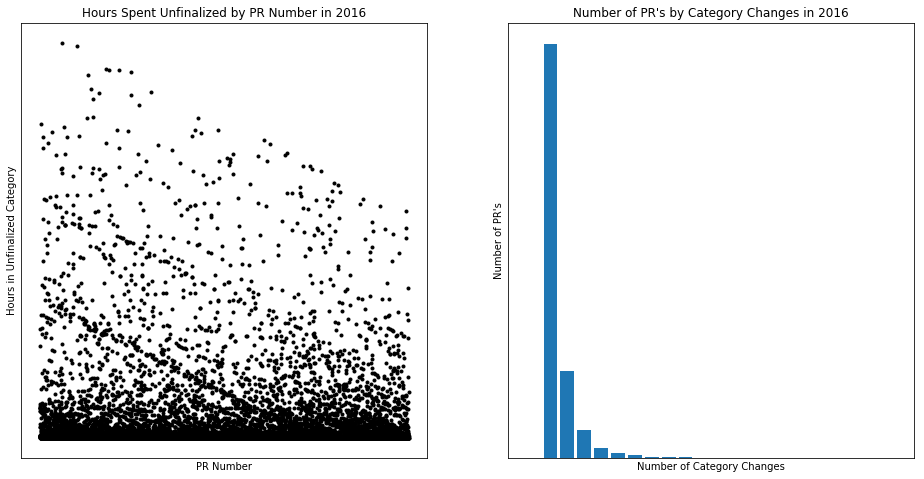

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))      

# Only plot those PR's which have had a category change
changed_df = uniq_prs_df[uniq_prs_df["Time-Misclassified"] >= 0.0]

keys = list(map(int, changed_df["Number"].as_matrix())) # list(map(int, mis_times.keys()))
vals = changed_df["Time-Misclassified"].as_matrix() # list(map(secs2hrs, mis_times.values()))
print("Problem Report numerical data removed in order to retain confidentiality")
ax1.set_title('Hours Spent Unfinalized by PR Number in 201X')
ax1.set_xlabel("PR Number")
ax1.set_ylabel("Hours in Unfinalized Category")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.scatter(keys, vals, color='black', marker='.')
   
num_changes_len = len(num_changes)
num_changes_range = range(num_changes_len)

ax2.set_xlabel("Number of Category Changes")
ax2.set_ylabel("Number of PR's")
ax2.set_xticks([]) # in order to hide proprietary data
ax2.set_yticks([])
#ax2.set_xticks(num_changes_range)
ax2.set_title('Number of PR\'s by Category Changes in 201X')
ax2.bar(num_changes_range, num_changes)

plt.show()

<div class="alert alert-success" role="alert" style="margin: 10px">
<p>
**Plotting the data, some interesting patterns and attributes appeared.** <br\> <br\>
</p>
<p>
**First, in the scatterplot on the left, several details of the underlying dataset become visible. 
The y-axis is highly correlated with the x-axis in that earlier problem reports are, not surprisingly,
able to have a larger amount of time "unfinalized".<br/> <br\>
The hours spent per PR in an unfinalized category have an upper limit based on the PR Number, 
which acts as a timestamp of the arrival date. For the highest data points, these show PR's that spent 
>90% in the incorrect category. For most of the PR's, the hours spent "unfinalized" were close to zero, 
as one would hope for. Interestingly, there appears to be linear relationships in the middle of the plot, 
a phenomenon that I will investigate further later in the analysis. <br\> <br\>
**
</p>
<p>
**For the barplot on the right, the visualization shows good behavior for the most, having few changes for 
most PR's. However, this graph also highlights outliers that have many, many changes. 
**
</p>
</div>

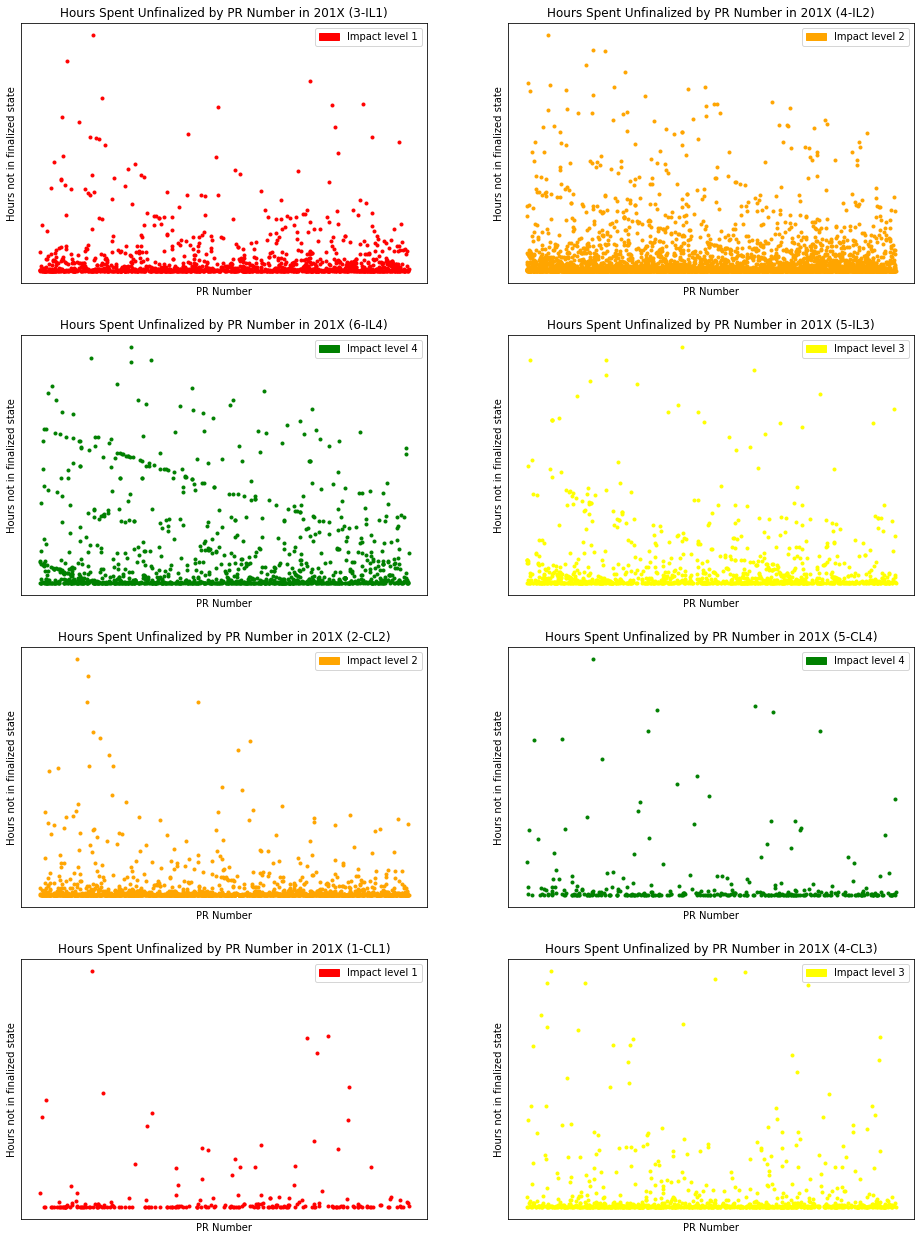

In [28]:
import matplotlib.patches as mpatches

f, axes = plt.subplots(4, 2, figsize=(16,22))      
problem_levels = uniq_prs_df["Problem-Level"].drop_duplicates().values
impact_colors = ["red","orange","yellow","green"]
impact_color_map = [(i+1, impact_color) for i, impact_color in enumerate(impact_colors)]

def scatter_plot_by_problem_level(axis, problem_level):
    pl_df = changed_df[changed_df["Problem-Level"] == problem_level]
    keys = list(map(int, pl_df["Number"].as_matrix()))
    vals = pl_df["Time-Misclassified"].as_matrix() 
    impact = int(problem_level[-1])
    
    legend_patch = mpatches.Patch(color=impact_colors[impact-1], label='Impact level '+str(impact))
    axis.legend(handles=[legend_patch])
    axis.set_title('Hours Spent Unfinalized by PR Number in 201X ({})'.format(problem_level))
    axis.set_xlabel("PR Number")
    axis.set_ylabel("Hours not in finalized state")
    axis.set_xticks([])
    axis.set_yticks([])
    axis.scatter(keys, vals, color=impact_colors[impact-1], marker='.')
    
pl_axes = list(zip(axes.flatten(), problem_levels))
for axis, problem_level in pl_axes:
    scatter_plot_by_problem_level(axis, problem_level)
plt.show()

<div class="alert alert-success" role="alert" style="margin: 10px">
<p>
**Splitting the scatterplot by problem-level tells a better story.<br\> <br\>
For the most part, these graphs show healthy workflows. The higher priority/impact PR's have, 
on average, less time spent unfinalized. <br/> <br/>
This split also isolates the linear relationships shown before. These are likely due to the 
renaming/restructuring of a team, and thus a mass category change that is tied to the PR's 
arrival.
**
</p>
</div>

Number of categories: "A lot"


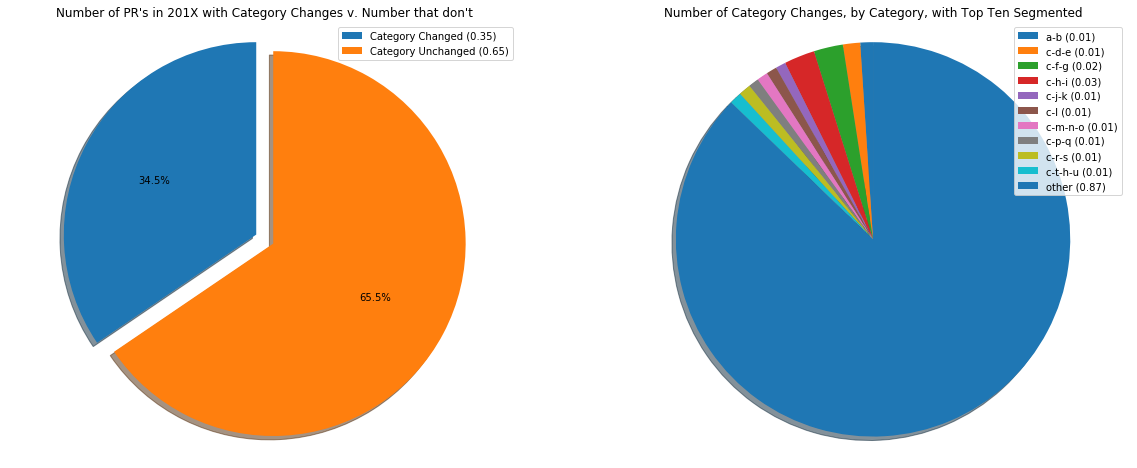

In [38]:
import string
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))   

percent_changed = num_changelog_prs/num_prs_2016
percent_unchanged = 1.0-percent_changed

ax1.set_title('Number of PR\'s in 201X with Category Changes v. Number that don\'t')
explode = (0.1, 0.0)
sizes = (percent_changed, percent_unchanged)
labels=[r'Category Changed (%.2f)' % percent_changed,
        r'Category Unchanged (%.2f)' % percent_unchanged]
patches, texts, _v = ax1.pie(sizes, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(patches, labels, loc="best")

categories = list(uniq_prs_df["Category"].drop_duplicates().values)
print('Number of categories: "A lot"') #{}'.format(len(categories)))
sizes = []
for category in categories:
    sizes.append(uniq_prs_df[(uniq_prs_df["Category"]==category) & 
                 (uniq_prs_df["Time-Misclassified"] >= 0.0)].shape[0])

top_ten_category_sizes = []
for category, size in zip(categories, sizes):
    if len(top_ten_category_sizes) < 10:
        top_ten_category_sizes.append((category, size))
        categories.remove(category)
        sizes.remove(size)
    else:
        min_elem = min(top_ten_category_sizes, key=lambda x:x[1])
        if min_elem[1] < size:
            top_ten_category_sizes.remove(min_elem)
            top_ten_category_sizes.append((category, size))
            categories.remove(category)
            sizes.remove(size)
            categories.append(min_elem[0])
            sizes.append(min_elem[1])
            

def anonymize_categories(top_ten_categories):
    substitutions = {}
    alphabet_ind = 0
    alphabet = list(string.ascii_lowercase)
    top_ten_categories_anon = []
    for category in top_ten_categories:
        cat_split = category.split('-')
        anon_cat = []
        for symbol in cat_split:
            if symbol not in substitutions:
                substitutions[symbol] = alphabet[alphabet_ind]
                alphabet_ind+=1
            anon_cat.append(substitutions[symbol])
        top_ten_categories_anon.append(anon_cat)
    return list(map(lambda x: '-'.join(x), top_ten_categories_anon))

ttcats = anonymize_categories([x[0] for x in top_ten_category_sizes])
ttsizs = [x[1] for x in top_ten_category_sizes]
other_size = sum(sizes)
total_size = other_size+sum(ttsizs)
other_perc = other_size/float(total_size)
ttperc = []
for ttsize in ttsizs:
    ttperc.append(ttsize/float(total_size))
percs = ttperc+[other_perc]
labels = [r'%s (%.2f)' % (label, perc) for label, perc in zip(ttcats+["other"], percs)]
ax2.set_title('Number of Category Changes, by Category, with Top Ten Segmented')
patches, texts = ax2.pie(percs, shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.legend(patches, labels, loc="best")
plt.show()

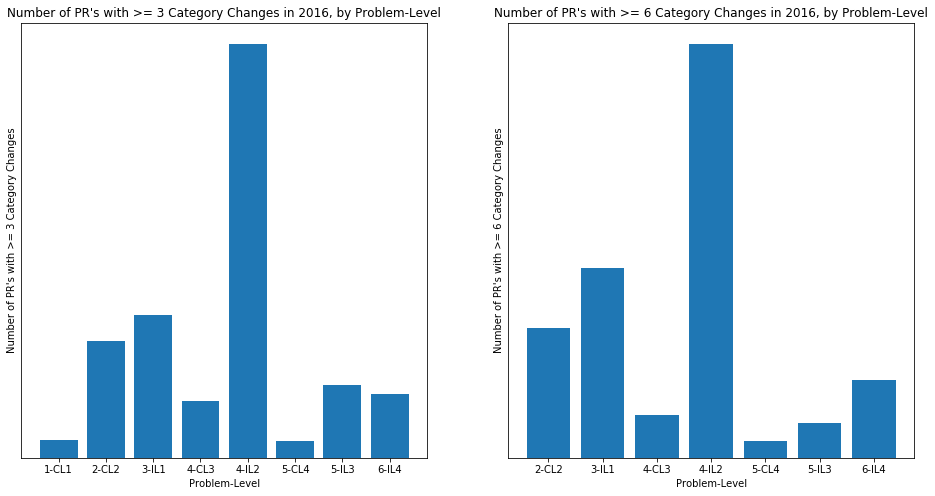

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))   

over_3_changes_pl_buckets = changed_df[changed_df["Num-Changes"] >= 3]
level_counts = [(group_key, len(group_list)) for group_key, group_list in 
                over_3_changes_pl_buckets.groupby("Problem-Level")]
plot_levels = [x[0] for x in level_counts]
plot_nums   = [x[1] for x in level_counts]

ax1.set_title('Number of PR\'s with >= 3 Category Changes in 2016, by Problem-Level')
ax1.set_xlabel("Problem-Level")
ax1.set_ylabel("Number of PR\'s with >= 3 Category Changes")

x = range(len(plot_levels))
ax1.bar(x, plot_nums)
ax1.set_xticks(x)
ax1.set_yticks([])
ax1.set_xticklabels(plot_levels)
    
over_6_changes_pl_buckets = changed_df[changed_df["Num-Changes"] >= 6]
level_counts = [(group_key, len(group_list)) for group_key, group_list in 
                over_6_changes_pl_buckets.groupby("Problem-Level")]
plot_levels = [x[0] for x in level_counts]
plot_nums   = [x[1] for x in level_counts]

ax2.set_title('Number of PR\'s with >= 6 Category Changes in 2016, by Problem-Level')
ax2.set_xlabel("Problem-Level")
ax2.set_ylabel("Number of PR\'s with >= 6 Category Changes")
        
x = range(len(plot_levels))
ax2.bar(x, plot_nums)
ax2.set_xticks(x)
ax2.set_yticks([])
ax2.set_xticklabels(plot_levels)
plt.show()

<div class="alert alert-info" role="alert" style="margin: 10px">
<p>
**\*Data has been anonymized to protect individuals and retain PR confidentiality. Only permitted, 
aggregated, stripped information is shown.
**
</p>
</div>